In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
# Updat the location of the csv if location is different.
bk = pd.read_csv(r'C:\Users\aghou\17\bank+marketing\bank-additional\bank-additional\bank-additional-full.csv', sep=";")
bk.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [2]:
#EDA - Exploratory Data Analysis
#print(bk.isnull().sum(), bk.shape)
#for column in bk.columns:
#    print(bk[column].value_counts())
#print(bk['poutcome'].value_counts())
#print(bk.columns)
columns_to_str = ['y', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
bk[columns_to_str] = bk[columns_to_str].astype(str)
print(bk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [3]:
# Define which columns to one-hot encode, which to standard scale, categorical encoding with get_dummies, drop etc.
bk_df = bk.drop('contact', axis=1)
bk_df['y'] = bk_df['y'].replace({'yes': 1, 'no': 0})
bk_df = pd.get_dummies(bk_df, columns=['month'], prefix='month')
bk_df = pd.get_dummies(bk_df, columns=['day_of_week'], prefix='day')
one_hot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
scaler_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Create a column transformer without remainder='passthrough'
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), one_hot_columns),  # Apply OneHotEncoder to categorical columns
    (StandardScaler(), scaler_columns),              # Apply StandardScaler to numeric columns
    remainder='passthrough'
)

# Fit and transform the data using the column transformer
transformed_data = preprocessor.fit_transform(bk_df)
feature_names = preprocessor.get_feature_names_out(input_features=bk_df.columns)
bkclean_df = pd.DataFrame(transformed_data, columns=feature_names)
print(bkclean_df.shape)
print(bkclean_df.columns)

(41188, 55)
Index(['onehotencoder__job_blue-collar', 'onehotencoder__job_entrepreneur',
       'onehotencoder__job_housemaid', 'onehotencoder__job_management',
       'onehotencoder__job_retired', 'onehotencoder__job_self-employed',
       'onehotencoder__job_services', 'onehotencoder__job_student',
       'onehotencoder__job_technician', 'onehotencoder__job_unemployed',
       'onehotencoder__job_unknown', 'onehotencoder__marital_married',
       'onehotencoder__marital_single', 'onehotencoder__marital_unknown',
       'onehotencoder__education_basic.6y',
       'onehotencoder__education_basic.9y',
       'onehotencoder__education_high.school',
       'onehotencoder__education_illiterate',
       'onehotencoder__education_professional.course',
       'onehotencoder__education_university.degree',
       'onehotencoder__education_unknown', 'onehotencoder__default_unknown',
       'onehotencoder__default_yes', 'onehotencoder__housing_unknown',
       'onehotencoder__housing_yes', 'onehot

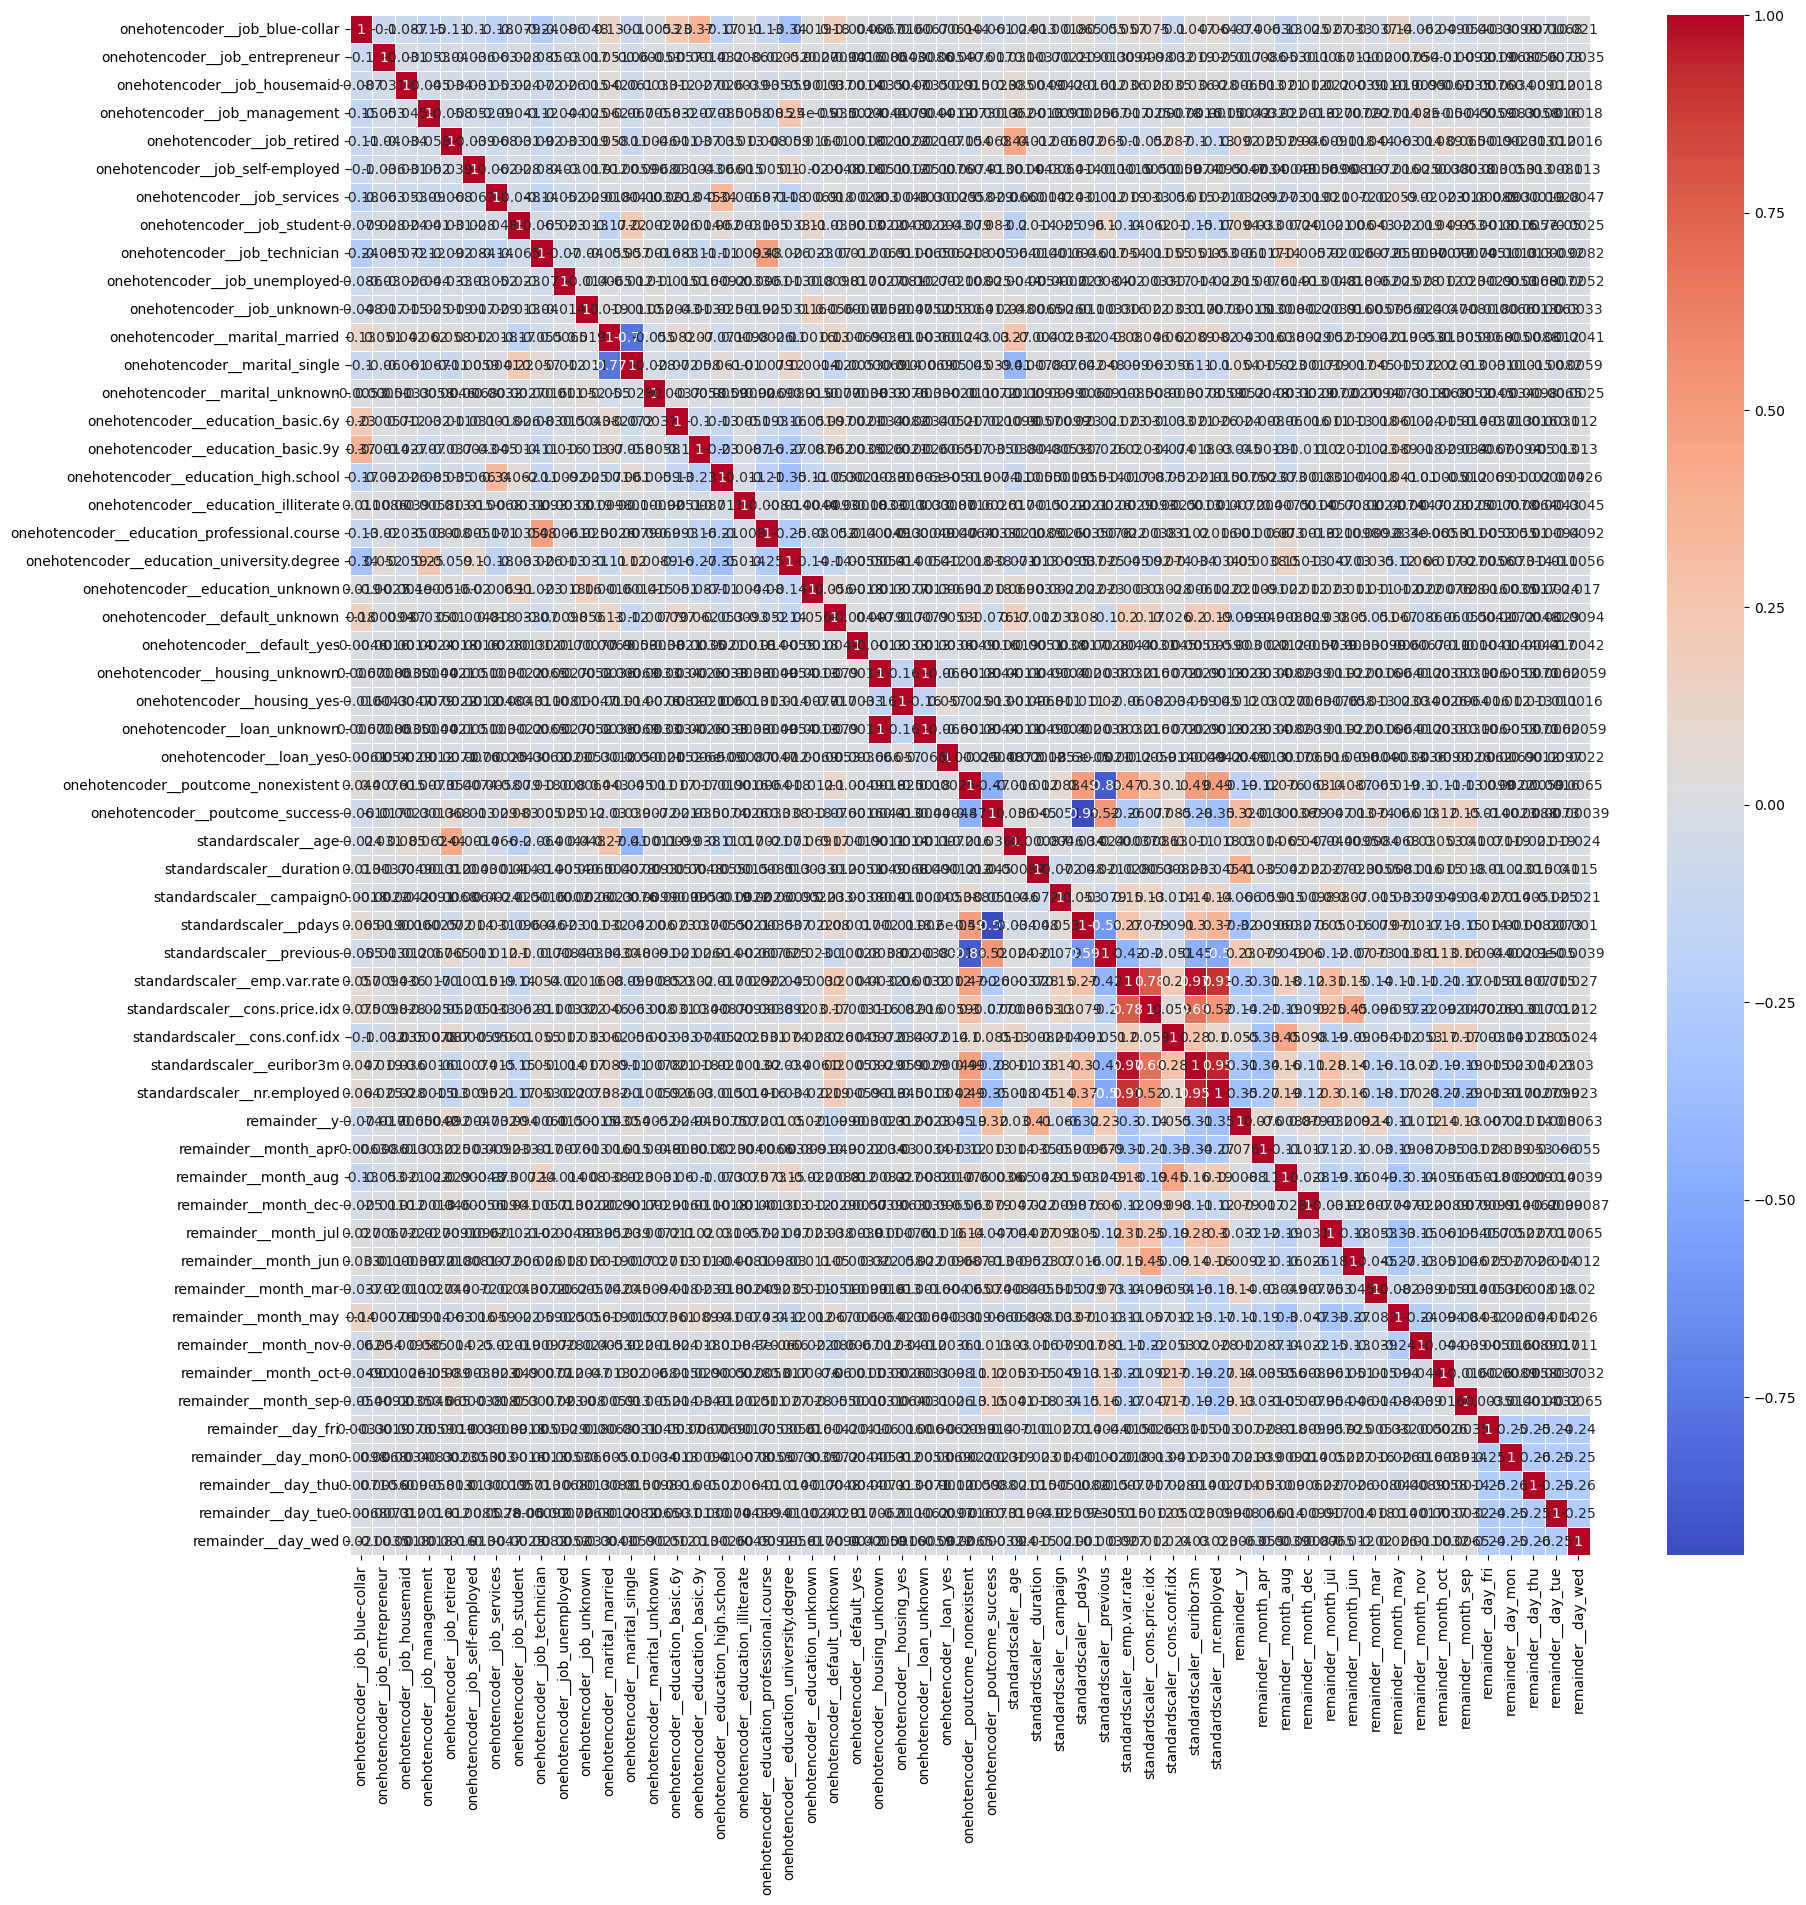

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = bkclean_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

#Output is too many to make any meaningful decision. 
#So we need to come up with an alternate approach to reduce feature sets.
#Perhaps manual setting threshold value and examining correlation_matrix. 


In [7]:
# Define a correlation threshold and reducing features to minimize computational expense and model analysis stability.
correlation_threshold = 0.7

# Find pairs of highly correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Drop/print the highly correlated features
print('highly - corelated features', correlated_features)
bk_r1_df = bkclean_df.drop(columns=correlated_features)
print(bk_r1_df.shape)
# Shape of the original input data or dataframe is now reduced from 
# (41188, 55) => (41188, 48)

highly - corelated features {'standardscaler__cons.price.idx', 'standardscaler__nr.employed', 'standardscaler__pdays', 'standardscaler__euribor3m', 'standardscaler__previous', 'onehotencoder__loan_unknown', 'onehotencoder__marital_single'}
(41188, 48)


In [8]:
# Initial Analysis using SVM Support Vector Machine - modeling. 
# Initial analysis with various paramaters and output was recorded. (summary  is captured at the bottom of this code section)
X = bk_r1_df.drop('remainder__y', axis=1)
y = bk_r1_df['remainder__y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=500, random_state=42)
start_time1 = time.time()
rf.fit(X_train, y_train)
end_time1 = time.time()

#Select Important Features:
#Use the trained Random Forest to select the most important features. 
#You can choose a threshold to determine how many features to keep based on feature importance scores.
sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
sfm.fit(X_train, y_train)
X_train_reduced = sfm.transform(X_train)
X_test_reduced = sfm.transform(X_test)
#Train an SVC on the Reduced Feature Set:
svc = SVC()
start_time2 = time.time()
svc.fit(X_train_reduced, y_train)
end_time2 = time.time()

#Evaluate the Model:
accuracy = svc.score(X_test_reduced, y_test)
y_pred = svc.predict(X_test_reduced)
balanced_accuracy = np.mean(y_test == y_pred)
##>>>>>>>
# Get the selected feature indices
selected_feature_indices = sfm.get_support(indices=True)

# Get the original column names from the DataFrame
original_feature_names = X.columns

# Create a list of reduced feature names
reduced_feature_names = [original_feature_names[i] for i in selected_feature_indices]

# Print the reduced feature names
print("Reduced Feature Names:")
for feature in reduced_feature_names:
    print(feature)
##>>>>>>>>

print(f"Accuracy on the testing set: {accuracy}")

# Print results
model_name = 'RandomForestClassifier(FeatureReduction)+SVC'
print(f"Model: {model_name}")
print(f"Fit Time: {(end_time2 - start_time2) + (end_time1 - start_time1):.4f} seconds")
print(f"Model: {model_name}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

#Recorded Outputs for RandomForestClassifier with various n_estimator and thresholds.
#rf = RandomForestClassifier(n_estimators=500, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.2)  # Adjust the threshold as needed
#Reduced Feature Names:
#standardscaler__duration
#Accuracy on the testing set: 0.8953629521728574

#rf = RandomForestClassifier(n_estimators=500, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.1)  # Adjust the threshold as needed
#Reduced Feature Names:
#standardscaler__age
#standardscaler__duration
#Accuracy on the testing set: 0.8964554503520272

#sfm = SelectFromModel(rf, threshold=0.1)  # Adjust the threshold as needed
#rf = RandomForestClassifier(n_estimators=1000, random_state=42)
#Reduced Feature Names:
#standardscaler__age
#standardscaler__duration
#Accuracy on the testing set: 0.8964554503520272

#rf = RandomForestClassifier(n_estimators=1000, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
#Reduced Feature Names:
#onehotencoder__poutcome_success
#standardscaler__age
#standardscaler__duration
#standardscaler__emp.var.rate
#standardscaler__cons.conf.idx
#Accuracy on the testing set: 0.9122359796067007

#rf = RandomForestClassifier(n_estimators=500, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
#Reduced Feature Names:
#onehotencoder__poutcome_success
#standardscaler__age
#standardscaler__duration
#standardscaler__emp.var.rate
#standardscaler__cons.conf.idx
#Accuracy on the testing set: 0.9122359796067007

#rf = RandomForestClassifier(n_estimators=500, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
# Additional output.
#Reduced Feature Names:
#onehotencoder__poutcome_success
#standardscaler__age
#standardscaler__duration
#standardscaler__emp.var.rate
#standardscaler__cons.conf.idx
#Accuracy on the testing set: 0.9122359796067007
#Model: RandomForestClassifier(FeatureReduction)+SVC
#Fit Time: 88.0431 seconds
#Model: RandomForestClassifier(FeatureReduction)+SVC
#Balanced Accuracy: 0.9122

# Tried SVM ( default kernel which is Radial Basis Function (RBF) kernel) 
# computationally this took too long crashing the system.)
# so reducing the features using RandomForestClassifier and choosing the absolutely best features made it practical.
# Then these features were fed in to SVM - SVC (Support Vector Machine - Support Vector Classifier) to classify the target
# which is binary "1" for marketing target to accept the terms deposit or "0" for not a target

# Final accuracy of 91.22% was obtained with 
#rf = RandomForestClassifier(n_estimators=500, random_state=42)
#sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
# Results are captured above.

Reduced Feature Names:
onehotencoder__poutcome_success
standardscaler__age
standardscaler__duration
standardscaler__emp.var.rate
standardscaler__cons.conf.idx
Accuracy on the testing set: 0.9122359796067007
Model: RandomForestClassifier(FeatureReduction)+SVC
Fit Time: 36.9805 seconds
Model: RandomForestClassifier(FeatureReduction)+SVC
Balanced Accuracy: 0.9122


Majority of the clients with Mktng campaign endup with unsuccessful campaign on enrolement represented as 0
Clients with Mktng campaign successful is represented as 1
0.0    0.887346
1.0    0.112654
Name: remainder__y, dtype: float64
Baseline Accuracy: 0.8873458288821987


Model: Logistic Regression
Balanced Accuracy: 0.9108
Fit Time: 0.5984 seconds
Interpretable: Yes

Model: Decision Tree
Balanced Accuracy: 0.8758
Fit Time: 0.2466 seconds
Interpretable: Yes

Model: K-Nearest Neighbors
Balanced Accuracy: 0.9037
Fit Time: 0.0000 seconds
Interpretable: No

Reduced X_train and X_test Size (32950, 5) (8238, 5)
Selected features post reduction by RandomForest: ['onehotencoder__poutcome_success', 'standardscaler__age', 'standardscaler__duration', 'standardscaler__emp.var.rate', 'standardscaler__cons.conf.idx']
Reduced Feature Names:
onehotencoder__poutcome_success
standardscaler__age
standardscaler__duration
standardscaler__emp.var.rate
standardscaler__cons.conf.idx
Accuracy on the testing s

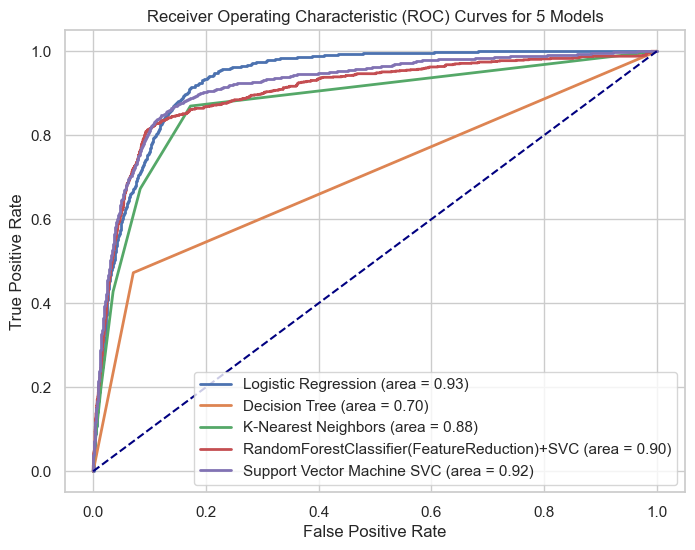

Summary Results:
                                          Model  Balanced Accuracy  \
0                           Logistic Regression           0.910779   
1                                 Decision Tree           0.875819   
2                           K-Nearest Neighbors           0.903739   
3  RandomForestClassifier(FeatureReduction)+SVC           0.912236   
4                    Support Vector Machine SVC           0.915635   

   Fit Time (s) Interpretable  
0      0.598370          True  
1      0.246648          True  
2      0.000000         False  
3     38.143940         False  
4     27.071441         False  


,Model,Balanced Accuracy,Fit Time (s),Interpretable
0,Logistic Regression,0.910779,0.598370,True
1,Decision Tree,0.875819,0.246648,True
2,K-Nearest Neighbors,0.903739,0.000000,False
3,RandomForestClassifier(FeatureReduction)+SVC,0.912236,38.143940,False
4,Support Vector Machine SVC,0.915635,27.071441,False


In [44]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


##
#establishing Baseline accuracy
##
Baccuracy = 0.0
print('Majority of the clients with Mktng campaign endup with unsuccessful campaign on enrolement represented as 0') 
print('Clients with Mktng campaign successful is represented as 1')
print(bk_r1_df['remainder__y'].value_counts(normalize=True))
majority_class = bk_r1_df['remainder__y'].value_counts().idxmax()
baseline_predictions = [majority_class] * len(bk_r1_df['remainder__y'])
#Calculate the accuracy of the baseline model:
Baccuracy = accuracy_score(bk_r1_df['remainder__y'], baseline_predictions)
print("Baseline Accuracy:", Baccuracy)
print("\n")

X = bk_r1_df.drop('remainder__y', axis=1)
y = bk_r1_df['remainder__y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC()
}

# Initialize lists to store evaluation results
model_names = []
balanced_accuracy_scores = []
fit_times = []
interpretability = []

#Key to enable / disable Feature selection using RandomForest for Analysis
#SVM_Feature_reduction_key = 1  to enable reduction and 0 to disable
#SVM_Feature_reduction_key = 0
SVM_Feature_reduction_key = 1
#>>>>
values = {}
#>>>>
# Loop through each model
for model_name, model in models.items():
    
    if SVM_Feature_reduction_key == 1 and model_name == 'Support Vector Machine':
        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        start_time1 = time.time()
        rf.fit(X_train, y_train)
        end_time1 = time.time()
        #Select Important Features:
        #Use the trained Random Forest to select the most important features. 
        #You can choose a threshold to determine how many features to keep based on feature importance scores.
        sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
        sfm.fit(X_train, y_train)
        X_train_reduced = sfm.transform(X_train)
        X_test_reduced = sfm.transform(X_test)
        
        #Size of the reduced X_train and X_test
        print("Reduced X_train and X_test Size", X_train_reduced.shape, X_test_reduced.shape)
        #Selected features for analysis by random forest
        selected_feature_mask = sfm.get_support()  # Mask of selected features
        selected_features = list(X_train.columns[selected_feature_mask])  # Get the names of the selected features
        print("Selected features post reduction by RandomForest:", selected_features)
        
        #Train an SVC on the Reduced Feature Set:
        svc = SVC()
        start_time2 = time.time()
        svc.fit(X_train_reduced, y_train)
        end_time2 = time.time()
        #Evaluate the Model:
        accuracy = svc.score(X_test_reduced, y_test)
        y_pred = svc.predict(X_test_reduced)
        balanced_accuracy = np.mean(y_test == y_pred)
        ##>>>>>>>
        # Get the selected feature indices
        selected_feature_indices = sfm.get_support(indices=True)

        # Get the original column names from the DataFrame
        original_feature_names = X.columns

        # Create a list of reduced feature names
        reduced_feature_names = [original_feature_names[i] for i in selected_feature_indices]

        # Print the reduced feature names
        print("Reduced Feature Names:")
        for feature in reduced_feature_names:
            print(feature)
        ##>>>>>>>>

        print(f"Accuracy on the testing set: {accuracy}")

        # Print results
        
        print(f"Model: {model_name}", 'With RandomForest feature reduction')
        print(f"Fit Time: {(end_time2 - start_time2) + (end_time1 - start_time1):.4f} seconds")
        print(f"Model: {model_name}")
        print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
        model_names.append('RandomForestClassifier(FeatureReduction)+SVC')
        balanced_accuracy_scores.append(balanced_accuracy)
        fit_times.append((end_time2 - start_time2) + (end_time1 - start_time1))
        interpretable = 'False'
        interpretability.append(interpretable)
        #>>>>
        fun_model = model
        model.fit(X_train_reduced, y_train)
        model_name = 'RandomForestClassifier(FeatureReduction)+SVC'
        values[f"{model_name}_y_score"] = fun_model.decision_function(X_test_reduced)
        values[f"{model_name}_fpr"], values[f"{model_name}_tpr"], values[f"{model_name}_thresholds"] = roc_curve(y_test, values[f"{model_name}_y_score"])
        values[f"{model_name}_roc_auc"] = auc(values[f"{model_name}_fpr"], values[f"{model_name}_tpr"])
        # Syntax for fpr, tpr and thresholds, fpr_svmr, tpr_svmr, thresholds_svmr = roc_curve(y_test, y_score)
        #roc_auc_svmr = auc(fpr_svmr, tpr_svmr)
        print(values[f"{model_name}_roc_auc"])
        #>>>>
    
    #else:
    # Measure time to train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # Calculate balanced accuracy score (good for imbalanced classes)
    y_pred = model.predict(X_test)
    balanced_accuracy = np.mean(y_test == y_pred)

    # Evaluate interpretability (you can customize this based on your criteria)
    # Here, we'll use a simple check if the model is a decision tree or logistic regression
    interpretable = isinstance(model, DecisionTreeClassifier) or isinstance(model, LogisticRegression)
    
    #>>>>
    if model_name == 'Decision Tree':
            dt_classifier = model
            dt_classifier.fit(X_train, y_train)
            values[f"{model_name}_y_score"] = dt_classifier.predict_proba(X_test)
            values[f"{model_name}_fpr"], values[f"{model_name}_tpr"], _ = roc_curve(y_test, values[f"{model_name}_y_score"][:, 1])
            values[f"{model_name}_roc_auc"] = auc(values[f"{model_name}_fpr"], values[f"{model_name}_tpr"])
            #y_score = dt_classifier.predict_proba(X_test)
            #fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
            #roc_auc = auc(fpr, tpr)
    elif model_name == 'K-Nearest Neighbors':
        knn_classifier = model
        knn_classifier.fit(X_train, y_train)
        values[f"{model_name}_y_score"] = knn_classifier.predict_proba(X_test)
        values[f"{model_name}_fpr"], values[f"{model_name}_tpr"], _ = roc_curve(y_test, values[f"{model_name}_y_score"][:, 1])
        values[f"{model_name}_roc_auc"] = auc(values[f"{model_name}_fpr"], values[f"{model_name}_tpr"])        
        #y_score = knn_classifier.predict_proba(X_test)
        #fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        #roc_auc = auc(fpr, tpr)
    elif model_name == 'Logistic Regression':
        fun_model = model
        model.fit(X_train, y_train)
        values[f"{model_name}_y_score"] = fun_model.decision_function(X_test)
        values[f"{model_name}_fpr"], values[f"{model_name}_tpr"], values[f"{model_name}_thresholds"] = roc_curve(y_test, values[f"{model_name}_y_score"])
        values[f"{model_name}_roc_auc"] = auc(values[f"{model_name}_fpr"], values[f"{model_name}_tpr"])
        # Syntax for fpr, tpr and thresholds, fpr_svmr, tpr_svmr, thresholds_svmr = roc_curve(y_test, y_score)
        #roc_auc_svmr = auc(fpr_svmr, tpr_svmr)
        #print(values[f"{model_name}_roc_auc"]) # This is to check auc computed value.
    else:
        fun_model = model
        model_name = 'Support Vector Machine SVC'
        model.fit(X_train, y_train)
        values[f"{model_name}_y_score"] = fun_model.decision_function(X_test)
        values[f"{model_name}_fpr"], values[f"{model_name}_tpr"], values[f"{model_name}_thresholds"] = roc_curve(y_test, values[f"{model_name}_y_score"])
        values[f"{model_name}_roc_auc"] = auc(values[f"{model_name}_fpr"], values[f"{model_name}_tpr"])
        # Syntax for fpr, tpr and thresholds, fpr_svmr, tpr_svmr, thresholds_svmr = roc_curve(y_test, y_score)
        #roc_auc_svmr = auc(fpr_svmr, tpr_svmr)
        #print(values[f"{model_name}_roc_auc"]) # This is to check auc computed value.
    #>>>>
    
    # Store results
    model_names.append(model_name)
    balanced_accuracy_scores.append(balanced_accuracy)
    fit_times.append(end_time - start_time)
    interpretability.append(interpretable)

    # Print results
    print(f"Model: {model_name}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Fit Time: {end_time - start_time:.4f} seconds")
    print(f"Interpretable: {'Yes' if interpretable else 'No'}\n")


# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Model': model_names,
    'Balanced Accuracy': balanced_accuracy_scores,
    'Fit Time (s)': fit_times,
    'Interpretable': interpretability
})

#>>>>
# Plot ROC curve to summarize results
modelnames = results_df['Model']
# Plot 5 different ROC curves
plt.figure(figsize=(8, 6))

# Accumulate values for all models
for modelname in modelnames:
    # Assuming values contain the FPR, TPR, and AUC values for each model
    fpr = values[f"{modelname}_fpr"]
    tpr = values[f"{modelname}_tpr"]
    roc_auc = values[f"{modelname}_roc_auc"]
    plt.plot(fpr, tpr, lw=2, label=f'{modelname} (area = {roc_auc:.2f})')

# Add the diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for 5 Models')
plt.legend(loc='lower right')
plt.show()
#>>>>
# Print the summary results
print("Summary Results:")
print(results_df)
results_df.head()

#>>>>>>>>
# Sample run output has been captured below.
#Majority of the clients with Mktng campaign endup with unsuccessful campaign on enrolement represented as 0
#Clients with Mktng campaign successful is represented as 1
#0.0    0.887346
#1.0    0.112654
#Name: remainder__y, dtype: float64
#Baseline Accuracy: 0.8873458288821987


#Model: Logistic Regression
#Balanced Accuracy: 0.9108
#Fit Time: 0.6311 seconds
#Interpretable: Yes

#Model: Decision Tree
#Balanced Accuracy: 0.8803
#Fit Time: 0.2952 seconds
#Interpretable: Yes

#Model: K-Nearest Neighbors
#Balanced Accuracy: 0.9037
#Fit Time: 0.0168 seconds
#Interpretable: No

#Reduced X_train and X_test Size (32950, 5) (8238, 5)
#Selected features post reduction by RandomForest: ['onehotencoder__poutcome_success', 'standardscaler__age', 'standardscaler__duration', 'standardscaler__emp.var.rate', 'standardscaler__cons.conf.idx']
#Reduced Feature Names:
#onehotencoder__poutcome_success
#standardscaler__age
#standardscaler__duration
#standardscaler__emp.var.rate
#standardscaler__cons.conf.idx
#Accuracy on the testing set: 0.9122359796067007
#Model: Support Vector Machine With RandomForest feature reduction
#Fit Time: 38.0724 seconds
#Model: Support Vector Machine
#Balanced Accuracy: 0.9122
#0.9018170688040443
#Model: Support Vector Machine SVC
#Balanced Accuracy: 0.9156
#Fit Time: 27.0326 seconds
#Interpretable: No

#Summary Results:
#                                          Model  Balanced Accuracy  \
#0                           Logistic Regression           0.910779   
#1                                 Decision Tree           0.880311   
#2                           K-Nearest Neighbors           0.903739   
#3  RandomForestClassifier(FeatureReduction)+SVC           0.912236   
#4                    Support Vector Machine SVC           0.915635   


#Model	Balanced Accuracy	Fit Time (s)	Interpretable
#0	Logistic Regression	0.910779	0.554451	True
#1	Decision Tree	0.876912	0.240282	True
#2	K-Nearest Neighbors	0.903739	0.004997	False
#3	RandomForestClassifier(FeatureReduction)+SVC	0.912236	35.774482	False
#4	Support Vector Machine	0.915635	22.514778	False

# Please refer to the ROC Curve Summary in the image folder

In [ ]:
# Based on the ROC Curve and Analysis summary from the DataFrame ( key factor - Accuracy ) 
# for our business use case we can afford to fit the model ahead and then target the customers as long as its 
# Computing is feasable in ($) and aggreable amount of time. 

# Top three models are 
# Logistic Regression, 
# SVC (Support Vector Machine - including 48 features) and 
# RandomForestClassifier(reduced 5 features) + SVM-SVC

# Reviewing ROC Curve & DF summary - Resulting Model based on ML Analysis
# Logistic Regression gives good accuracy(91.07%) but False possitive rate increases as accuracy increases.
# SVM using SVC all features gives best accuracy (91.5%), since we can afford to spend some time and realistic amount of $
# If computing $ is a concern then RandomForestClassifier(FeatureReduction to 5 features)+SVC accuracy(91.22%)
#######
# Choice (1) SVM using SVC and all 48 features with accuracy (91.5%) seems to be a better fit for our application 
# Choice (2) If computing $ is a concern then RandomForestClassifier(FeatureReduction to 5 features)+SVC accuracy(91.22%)
# Choice (3) Logistic Regression with accuracy of (91.07%) , can target customers but false possitives are a bit more 
######

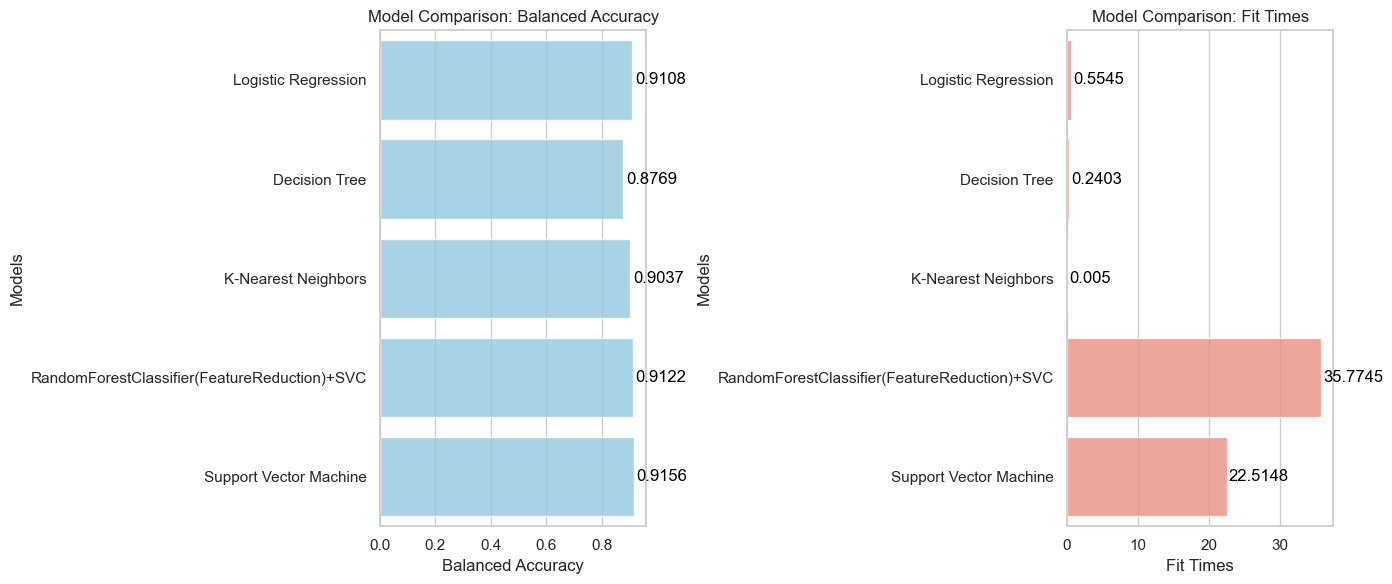

,Model,Balanced Accuracy,Fit Time (s),Interpretable
0,Logistic Regression,0.910779,0.554451,True
1,Decision Tree,0.876912,0.240282,True
2,K-Nearest Neighbors,0.903739,0.004997,False
3,RandomForestClassifier(FeatureReduction)+SVC,0.912236,35.774482,False
4,Support Vector Machine,0.915635,22.514778,False


In [10]:
# Visual representation of the analyzed models, version variation of models like SVM, fit times and Interpretability.
# Visualization as bargraphs and DataFrame.

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df contains the necessary data

# Set the style for the plots
sns.set(style="whitegrid")

# Creating the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for Balanced Accuracy
sns.barplot(x='Balanced Accuracy', y='Model', data=results_df, color='skyblue', alpha=0.8, ax=ax1)
ax1.set_xlabel('Balanced Accuracy')
ax1.set_ylabel('Models')
ax1.set_title('Model Comparison: Balanced Accuracy')
for i, v in enumerate(results_df['Balanced Accuracy']):
    ax1.text(v + 0.01, i, str(round(v, 4)), color='black', va='center')

# Second subplot for Fit Times
sns.barplot(x='Fit Time (s)', y='Model', data=results_df, color='salmon', alpha=0.8, ax=ax2)
ax2.set_xlabel('Fit Times')
ax2.set_ylabel('Models')
ax2.set_title('Model Comparison: Fit Times')
for i, v in enumerate(results_df['Fit Time (s)']):
    ax2.text(v + 0.3, i, str(round(v, 4)), color='black', va='center')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
results_df.head()

In [ ]:
#Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification 
#model. It illustrates the diagnostic ability of a model across various classification thresholds. The ROC curve is created 
#by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

#True Positive Rate (TPR) or Sensitivity: This is the proportion of actual positive cases that are correctly identified by 
#the model. 
#TPR = True Positive/(True Positive + False Negative)
#False Positive Rate (FPR): This is the proportion of actual negative cases that are incorrectly classified as positive.
#FPR = False Positive/(False Positive + True Negative)

#As the threshold for classification changes, the TPR and FPR also change, resulting in different points on the ROC curve. 
#The diagonal of the ROC space represents the line of no-discrimination (random guessing), and an ideal classifier would 
#have a point in the top-left corner, representing 100% TPR and 0% FPR.

#The ROC curve is useful for evaluating the performance of a classification model in the following ways:
#Threshold Selection, Model Comparison, Performance Evaluation, Class Imbalance, Model Robustness
#By analyzing the ROC curve and AUC, you can make informed decisions about your model's performance and 
#tune it to achieve better results.

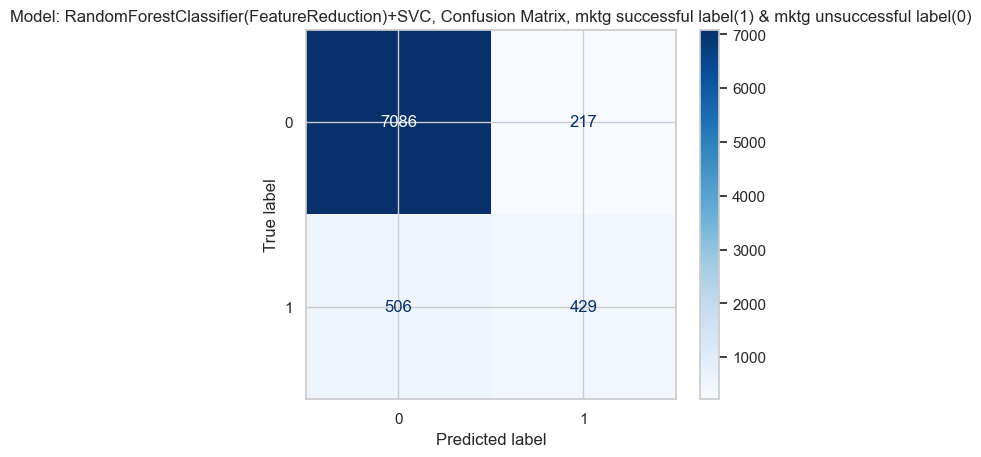

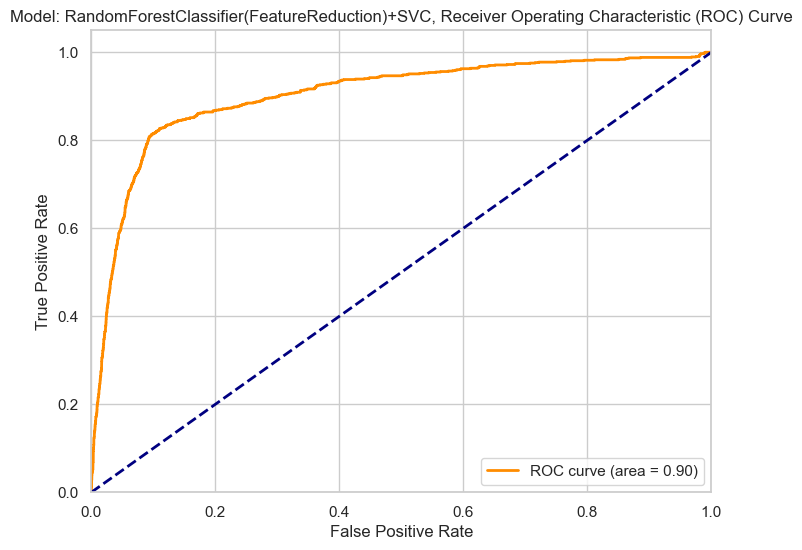

In [41]:
# Researching further on SVM with Reduced features.
# #####>>>>>>>>> Reduced features and using SVC  seems to be a better fit for our application <<<<<<<<<<<<<<<#######
# Further exploring SVM SVC with all 48 features.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, confusion_matrix


#>>>>
X_train = X_train_reduced
X_test = X_test_reduced
y_test = y_test
y_train = y_train
#>>>>


# Fit the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Generate predictions
y_pred = svm_model.predict(X_test)
y_score = svm_model.decision_function(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')

plt.title('Model: RandomForestClassifier(FeatureReduction)+SVC, Confusion Matrix, mktg successful label(1) & mktg unsuccessful label(0)')
plt.show()
#>>>
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model: RandomForestClassifier(FeatureReduction)+SVC, Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
'''
What next ?

In Support Vector Machines (SVM), kernel = rbf, the parameters C and gamma are crucial for optimizing the classification performance.
In the case of poly kernel in SVM degree and parameter C are crucial for classifier optimization.

C Parameter:
The C parameter is a regularization parameter that controls the trade-off between maximizing the margin and minimizing the 
classification error.A smaller value of C leads to a larger margin but more misclassifications, allowing for more violations
of the margin. This can result in a simpler decision boundary that may underfit the data.
A larger value of C implies a smaller margin but fewer misclassifications, leading to a more complex decision boundary that
may overfit the data. By tuning the C parameter, you can control the balance between model simplicity and classification 
accuracy.

Gamma Parameter:
The gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and 
high values meaning 'close'. A small value of gamma indicates a Gaussian function with a large variance. 
This leads to a smoother decision boundary and can result in underfitting. A large value of gamma indicates a Gaussian 
function with a smaller variance. This leads to a more complex decision boundary that can potentially overfit the data.
Adjusting the gamma parameter allows you to control the influence of individual training samples and can significantly 
impact the shape of the decision boundary. The optimization of these parameters is crucial in SVM as they influence the 
model's ability to generalize to unseen data. While a higher C value allows the model to fit the training data more 
accurately, it might not generalize well to unseen data. Similarly, an inappropriate choice of gamma can lead to overfitting
or underfitting.

Grid search cross-validation is commonly used to find the optimal values for degree, C and gamma. It systematically tests different 
combinations of these parameters, evaluating the model's performance using cross-validation. The optimal values are chosen 
based on the performance metrics, such as accuracy, obtained during this process.

By properly tuning the C and gamma parameters, you can effectively balance the trade-off between model complexity and 
generalization, resulting in an SVM model that performs well on unseen data.
'''

In [ ]:
# Next step to further improve the SVM model using gridsearchCV trying out various hyperparameters 
# and kernels will require powerful computing
#Attempts to do grid search to optimize hyper paramater is causing multiple hours or perhaps even days to 
# develop results. I barely was able to capture one result and its recorded in the comments section below.
# SVM (all Features  or 48 features ) - svc for sigmoid kernel - only successful result after few hours of computing.


import numpy as np
import time
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#>>>>>>
X = bk_r1_df.drop('remainder__y', axis=1)
y = bk_r1_df['remainder__y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Computationally expensive and takes too long to converge to a solution, recomending reducing features to move forward
#>>>>>>

rf = RandomForestClassifier(n_estimators=500, random_state=42)
start_time1 = time.time()
rf.fit(X_train, y_train)
end_time1 = time.time()
#Select Important Features:
#Use the trained Random Forest to select the most important features. 
#You can choose a threshold to determine how many features to keep based on feature importance scores.
sfm = SelectFromModel(rf, threshold=0.05)  # Adjust the threshold as needed
sfm.fit(X_train, y_train)
X_train_reduced = sfm.transform(X_train)
X_test_reduced = sfm.transform(X_test)
        
#Size of the reduced X_train and X_test
print("Reduced X_train and X_test Size", X_train_reduced.shape, X_test_reduced.shape)
#Selected features for analysis by random forest
selected_feature_mask = sfm.get_support()  # Mask of selected features
selected_features = list(X_train.columns[selected_feature_mask])  # Get the names of the selected features
print("Selected features post reduction by RandomForest:", selected_features)
#X = bk_r1_df.drop('remainder__y', axis=1)
#y = bk_r1_df['remainder__y']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#>>>>>>
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_reduced)
X_test = scaler.transform(X_test_reduced)

# Set the parameters to search
#param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100]}
param_grid = {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}

# Initialize the SVM model
#svm_model = SVC(kernel='rbf') #Compute Intenive 
svm_model = SVC(kernel='poly') 

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_C = grid_search.best_params_['C']
#best_gamma = grid_search.best_params_['gamma']
best_degree = grid_search.best_params_['degree']

# Train the model with the best parameters
#optimized_svm_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
#optimized_svm_model = SVC(kernel='poly', C=best_C, gamma=best_gamma, degree=best_degree)
optimized_svm_model = SVC(kernel='poly', C=best_C, degree=best_degree)
start_time = time.time()
optimized_svm_model.fit(X_train, y_train)
end_time = time.time()
# Make predictions
y_pred = optimized_svm_model.predict(X_test)

# Calculate accuracy
#print("Model:", 'Optimized SVM svc', 'Best paramaters C, gamma, degree', best_C, best_gamma, best_degree)
print("Model:", 'Optimized SVM svc', 'Best paramaters C, degree', best_C, best_degree)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f"Fit Time: {end_time - start_time:.4f} seconds")
#Recorded output
#Reduced X_train and X_test Size (32950, 5) (8238, 5)
#Selected features post reduction by RandomForest: ['onehotencoder__poutcome_success', 'standardscaler__age', 
#'standardscaler__duration', 'standardscaler__emp.var.rate', 'standardscaler__cons.conf.idx']
#Model: Optimized SVM svc Best paramaters C, gamma 0.1 0.1
#optimized_svm_model = SVC(kernel='sigmoid', C=best_C, gamma=best_gamma)
#Accuracy: 0.8868657441126487
#Fit Time: 12.2160 seconds
